### Implementation

In [3]:
from tensorflow import keras
import tensorflow.keras.backend as K
import os
import csv

base_base_dir = "C:\\Users\\dejoe\\git\\pneumonia-detection\\"
base_dir = os.path.join(base_base_dir, "input\chest_xray_new")
train_dir = os.path.join(base_dir, "train")
test_dir = os.path.join(base_dir, "test")
val_dir = os.path.join(base_dir, "val")

class SaveHistory(keras.callbacks.Callback):

  def on_epoch_end(self, batch, logs=None):
    if ('lr' not in logs.keys()):
      logs.setdefault('lr', 0)
      logs['lr'] = K.get_value(self.model.optimizer.lr)

    if not ('history.csv' in os.listdir(base_base_dir)):
      with open(base_base_dir + 'history.csv', 'a') as f:
        content = csv.DictWriter(f, logs.keys())
        content.writeheader()

    with open(base_base_dir + 'history.csv','a') as f:
      content = csv.DictWriter(f, logs.keys())
      content.writerow(logs)

ResNeXt Implementation

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Dense, Flatten, Activation, Add, Conv2D, BatchNormalization, AveragePooling2D, MaxPooling2D, Dropout, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.regularizers import l2
import pandas as pd

import os


In [5]:
# Define ImageDataGenerator instances
data_generator_1 = ImageDataGenerator(
    rescale=1./255,
    rotation_range=5,
    width_shift_range=0.05,
    height_shift_range=0.05,
    shear_range=0.05,
    zoom_range=0.05,
    brightness_range=[0.95, 1.05],
    horizontal_flip=False,
    vertical_flip=False,
    fill_mode='nearest'
)

data_generator_2 = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    brightness_range=[0.9, 1.1],
    horizontal_flip=False,
    vertical_flip=False,
    fill_mode='nearest'
)

data_generator_3 = ImageDataGenerator(rescale=1./255)

# Load data using generators
train_generator_1 = data_generator_1.flow_from_directory(
    train_dir,
    target_size=(64, 64),
    batch_size=32,
    class_mode='categorical'
)

train_generator_2 = data_generator_2.flow_from_directory(
    test_dir,
    target_size=(64, 64),
    batch_size=32,
    class_mode='categorical'
)

train_generator_3 = data_generator_3.flow_from_directory(
    val_dir,
    target_size=(64, 64),
    batch_size=32,
    class_mode='categorical'
)


Found 4697 images belonging to 2 classes.
Found 589 images belonging to 2 classes.
Found 586 images belonging to 2 classes.


### ResNeXt

In [220]:
# Define input shape
img_size = (64, 64)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

# Number of classes
class_count = len(list(train_generator_1.class_indices.keys()))

# Define grouped convolution block
def grouped_conv_block(x, filters, groups, kernel_size):
    channels_per_group = filters // groups
    groups_list = []

    for i in range(groups):
        group = Conv2D(channels_per_group, kernel_size, padding='same', activation='relu')(x)
        groups_list.append(group)

    return concatenate(groups_list)

# Define the ResNeXt50-like architecture
inputs = Input(shape=img_shape)
x = Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu', kernel_regularizer=l2(0.001))(inputs)
x = Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu', kernel_regularizer=l2(0.001))(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.2)(x)


x = grouped_conv_block(x, filters=128, groups=32, kernel_size=(3, 3))
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.2)(x)


x = grouped_conv_block(x, filters=256, groups=32, kernel_size=(3, 3))
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.3)(x)


x = grouped_conv_block(x, filters=512, groups=32, kernel_size=(3, 3))
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.3)(x)


x = grouped_conv_block(x, filters=512, groups=32, kernel_size=(3, 3))
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.4)(x)


x = Flatten()(x)
x = Dense(256, activation='relu', kernel_regularizer=l2(0.001))(x)
x = Dropout(0.5)(x)
x = Dense(64, activation='relu', kernel_regularizer=l2(0.001))(x)
outputs = Dense(2, activation='softmax')(x)


# Create the model
resnext_model = Model(inputs=inputs, outputs=outputs)

# Compile the model
resnext_model.compile(optimizer=Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
resnext_model.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv2d_708 (Conv2D)            (None, 64, 64, 64)   1792        ['input_11[0][0]']               
                                                                                                  
 conv2d_709 (Conv2D)            (None, 64, 64, 64)   36928       ['conv2d_708[0][0]']             
                                                                                                  
 max_pooling2d_82 (MaxPooling2D  (None, 32, 32, 64)  0           ['conv2d_709[0][0]']             
 )                                                                                          

In [12]:
history_resnext = resnext_model.fit(
    train_generator_1,
    steps_per_epoch=len(train_generator_1),
    epochs=10,
    validation_data=train_generator_2,
    validation_steps=len(train_generator_2), 
    callbacks=[keras.callbacks.CSVLogger('history-resnext.csv')]
)

Epoch 1/10
147/147 [==============================] - 272s 2s/step - loss: 1.1019 - accuracy: 0.7232 - val_loss: 1.0118 - val_accuracy: 0.7284
Epoch 2/10
147/147 [==============================] - 248s 2s/step - loss: 0.8843 - accuracy: 0.7528 - val_loss: 0.7357 - val_accuracy: 0.8387
Epoch 3/10
147/147 [==============================] - 257s 2s/step - loss: 0.6652 - accuracy: 0.8618 - val_loss: 0.7143 - val_accuracy: 0.8183
Epoch 4/10
147/147 [==============================] - 266s 2s/step - loss: 0.5497 - accuracy: 0.9021 - val_loss: 0.5193 - val_accuracy: 0.8947
Epoch 5/10
147/147 [==============================] - 254s 2s/step - loss: 0.4775 - accuracy: 0.9193 - val_loss: 0.4706 - val_accuracy: 0.9032
Epoch 6/10
147/147 [==============================] - 251s 2s/step - loss: 0.4409 - accuracy: 0.9214 - val_loss: 0.4063 - val_accuracy: 0.9287
Epoch 7/10
147/147 [==============================] - 249s 2s/step - loss: 0.3912 - accuracy: 0.9346 - val_loss: 0.3906 - val_accuracy: 0.9321

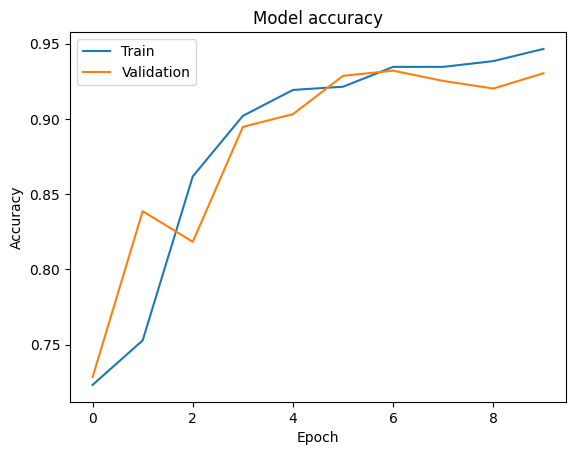

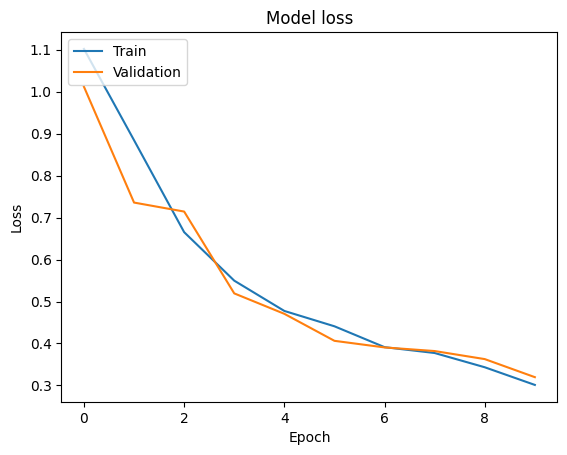

In [221]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [222]:
test_loss, test_accuracy = model.evaluate(train_generator_2, steps=len(train_generator_2))
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

19/19 [==============================] - 11s 527ms/step - loss: 0.3000 - accuracy: 0.9151
Test Loss: 0.29998767375946045
Test Accuracy: 0.9151103496551514


In [5]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
from tensorflow.keras.models import load_model

resnext__model = load_model(os.path.join(base_base_dir, "resnext50.h5"))

# Generate predictions
predictions = resnext__model.predict(train_generator_3)

# Convert predictions to class labels
predicted_classes = np.argmax(predictions, axis=1)

# Get true labels
true_classes = train_generator_3.classes

# Generate and print classification report
report = classification_report(true_classes, predicted_classes, target_names=train_generator_3.class_indices)
print("Classification Report:\n", report)

# Generate and plot confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)
print("Confusion Matrix:\n", conf_matrix)

19/19 [==============================] - 11s 504ms/step
Classification Report:
               precision    recall  f1-score   support

      NORMAL       0.28      0.34      0.31       158
   PNEUMONIA       0.74      0.68      0.71       428

    accuracy                           0.59       586
   macro avg       0.51      0.51      0.51       586
weighted avg       0.61      0.59      0.60       586

Confusion Matrix:
 [[ 53 105]
 [136 292]]


In [28]:
model.save('resnext50.h5')

### CNN Implementation

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import Adadelta
import tensorflow as tf

import cv2
import os

In [6]:

cnn = Sequential()

#Convolution
cnn.add(Conv2D(32, (3, 3), activation="relu", input_shape=(64, 64, 3)))

#Pooling
cnn.add(MaxPooling2D(pool_size = (2, 2)))

# 2nd Convolution
cnn.add(Conv2D(32, (3, 3), activation="relu"))

# 2nd Pooling layer
cnn.add(MaxPooling2D(pool_size = (2, 2)))

# Flatten the layer
cnn.add(Flatten())

# Fully Connected Layers
cnn.add(Dense(activation = 'relu', units = 128))
cnn.add(Dense(activation = 'sigmoid', units = 2))

# Compile the Neural network
cnn.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
cnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 31, 31, 32)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 29, 29, 32)        9248      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 6272)              0         
                                                                 
 dense_2 (Dense)             (None, 128)              

In [7]:
CALLBACKS = [ keras.callbacks.CSVLogger('history-cnn.csv')]

history_cnn = cnn.fit(
    train_generator_1,
    steps_per_epoch=len(train_generator_1),
    epochs=10,
    validation_data=train_generator_2,
    validation_steps=len(train_generator_2), 
    callbacks=CALLBACKS
)

Epoch 1/10
147/147 [==============================] - 77s 511ms/step - loss: 0.3886 - accuracy: 0.8327 - val_loss: 0.4402 - val_accuracy: 0.8387
Epoch 2/10
147/147 [==============================] - 85s 576ms/step - loss: 0.2116 - accuracy: 0.9159 - val_loss: 0.3626 - val_accuracy: 0.8455
Epoch 3/10
147/147 [==============================] - 83s 563ms/step - loss: 0.1803 - accuracy: 0.9289 - val_loss: 0.2861 - val_accuracy: 0.8693
Epoch 4/10
147/147 [==============================] - 76s 521ms/step - loss: 0.1665 - accuracy: 0.9387 - val_loss: 0.3987 - val_accuracy: 0.8540
Epoch 5/10
147/147 [==============================] - 77s 524ms/step - loss: 0.1614 - accuracy: 0.9366 - val_loss: 0.2678 - val_accuracy: 0.8710
Epoch 6/10
147/147 [==============================] - 93s 634ms/step - loss: 0.1565 - accuracy: 0.9406 - val_loss: 0.2805 - val_accuracy: 0.8795
Epoch 7/10
147/147 [==============================] - 81s 553ms/step - loss: 0.1479 - accuracy: 0.9461 - val_loss: 0.2492 - val_ac

In [8]:
cnn.save('cnn.h5')

In [9]:
test_loss, test_accuracy = cnn.evaluate(train_generator_2, steps=len(train_generator_2))
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

19/19 [==============================] - 9s 466ms/step - loss: 0.2691 - accuracy: 0.8930
Test Loss: 0.2691073417663574
Test Accuracy: 0.8930390477180481


### VGG16

In [115]:
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import os 

In [116]:
train_path = train_dir
val_path = val_dir
test_path = test_dir

In [117]:
# re-size all the images to a size VGG-16 expects.
IMAGE_SIZE = [64, 64]

# Set the batch size
BATCH_SIZE = 32  # try reducing batch size or freeze more layers if your GPU runs out of memory
NUM_EPOCHS = 10
LEARNING_RATE = 0.0001
NUM_CLASSES = 2 # We are aware of it.

In [118]:
import os
CLASSES = os.listdir(train_path)
NUM_CLASSES = len(CLASSES)
print("Class --> {} \n and the length is : {}".format(CLASSES, NUM_CLASSES))


Class --> ['NORMAL', 'PNEUMONIA'] 
 and the length is : 2


In [119]:
vgg = VGG16(input_shape = IMAGE_SIZE + [3], weights='imagenet', include_top=False)

In [120]:
# don't train existing weights
for layer in vgg.layers:
    layer.trainable = False

In [121]:
x = Flatten()(vgg.output)

prediction = Dense(NUM_CLASSES, activation='softmax')(x)

In [122]:
vgg16_model = Model(inputs=vgg.input, outputs=prediction)
# tell the model what cost and optimization method to use
vgg16_model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)
vgg16_model.summary()


Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0   

In [123]:
history_vgg16 = vgg16_model.fit(
    train_generator_1,
    steps_per_epoch=len(train_generator_1),
    epochs=10,
    validation_data=train_generator_2,
    validation_steps=len(train_generator_2), 
    callbacks=[keras.callbacks.CSVLogger('history-vgg16.csv')]
)

Epoch 1/10
147/147 [==============================] - 105s 706ms/step - loss: 0.3455 - accuracy: 0.8633 - val_loss: 0.2583 - val_accuracy: 0.8930
Epoch 2/10
147/147 [==============================] - 93s 634ms/step - loss: 0.1930 - accuracy: 0.9300 - val_loss: 0.2421 - val_accuracy: 0.8947
Epoch 3/10
147/147 [==============================] - 94s 639ms/step - loss: 0.1664 - accuracy: 0.9366 - val_loss: 0.2173 - val_accuracy: 0.9083
Epoch 4/10
147/147 [==============================] - 102s 692ms/step - loss: 0.1521 - accuracy: 0.9434 - val_loss: 0.1993 - val_accuracy: 0.9236
Epoch 5/10
147/147 [==============================] - 105s 711ms/step - loss: 0.1471 - accuracy: 0.9419 - val_loss: 0.1914 - val_accuracy: 0.9185
Epoch 6/10
147/147 [==============================] - 97s 662ms/step - loss: 0.1430 - accuracy: 0.9417 - val_loss: 0.2208 - val_accuracy: 0.9100
Epoch 7/10
147/147 [==============================] - 95s 648ms/step - loss: 0.1362 - accuracy: 0.9461 - val_loss: 0.2191 - val

In [124]:
vgg16_model.save('vgg16-pneumonia.h5')


### Plots

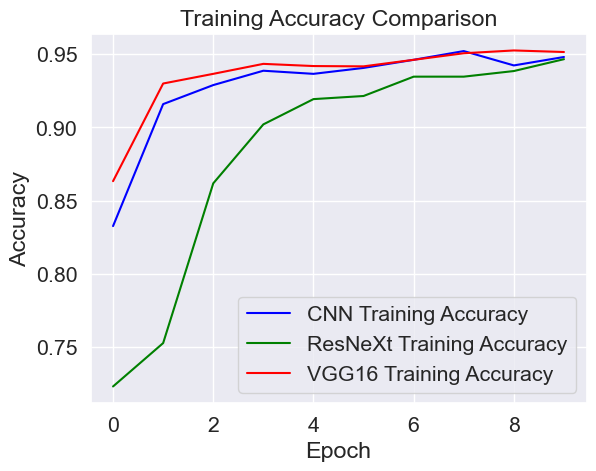

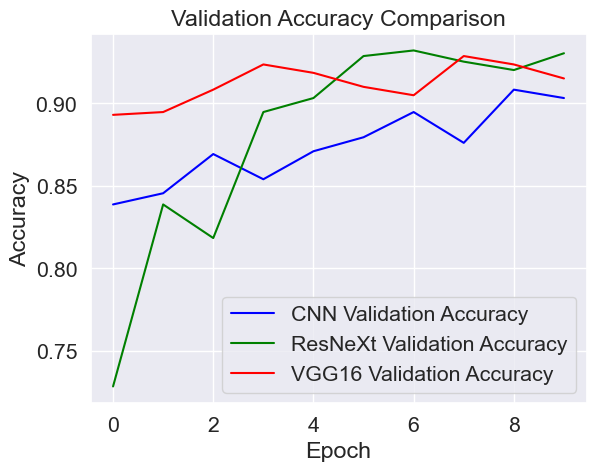

In [22]:
import pandas as pd
import matplotlib.pyplot as plt

# Load history data from CSV files
history_cnn = pd.read_csv(os.path.join(base_base_dir, 'history-cnn.csv'))
history_resnext = pd.read_csv(os.path.join(base_base_dir, 'history-resnext.csv'))
history_vgg16 = pd.read_csv(os.path.join(base_base_dir, 'history-vgg16.csv'))

# Plot training accuracies
plt.plot(history_cnn['accuracy'], label='CNN Training Accuracy', linestyle='-', color='blue')
plt.plot(history_resnext['accuracy'], label='ResNeXt Training Accuracy', linestyle='-', color='green')
plt.plot(history_vgg16['accuracy'], label='VGG16 Training Accuracy', linestyle='-', color='red')

# Add title and labels
plt.title('Training Accuracy Comparison')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Show plot
plt.show()

# Plot validation accuracies
plt.plot(history_cnn['val_accuracy'], label='CNN Validation Accuracy', linestyle='-', color='blue')
plt.plot(history_resnext['val_accuracy'], label='ResNeXt Validation Accuracy', linestyle='-', color='green')
plt.plot(history_vgg16['val_accuracy'], label='VGG16 Validation Accuracy', linestyle='-', color='red')

# Add title and labels
plt.title('Validation Accuracy Comparison')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Show plot
plt.show()


### Prediction on a given image

In [25]:
!pip install pillow
!pip install ipyfilechooser

In [1]:
import ipywidgets as widgets
import os
import random

def pick_random_file(path):
    # Check if the path exists
    if not os.path.exists(path):
        print(f"Error: Path '{path}' does not exist.")
        return None

    # Get a list of files in the directory
    files = [f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))]

    # Check if there are any files in the directory
    if not files:
        print(f"No files found in '{path}'.")
        return None

    # Pick a random file from the list
    random_file = random.choice(files)

    # Return the full path of the randomly selected file
    return os.path.join(path, random_file)

In [22]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import load_model
import numpy as np
from IPython.display import Image
from PIL import Image as PILImage

resnext__model = load_model(os.path.join(base_base_dir, "resnext50.h5"))
cnn__model = load_model(os.path.join(base_base_dir, "cnn.h5"))
vgg16__model = load_model(os.path.join(base_base_dir, "vgg16-pneumonia.h5"))

def predict(image_path):
    
    if model_type_id == resnext:
        loaded_model = resnext__model
        print("Using resnext")
        
    elif model_type_id == cnn:
        loaded_model = cnn__model
        print("Using cnn")
        
    elif model_type_id == vgg16:
        loaded_model = vgg16__model
        print("Using vgg16")

  
    img = load_img(image_path, target_size=(64, 64))
    img_array = img_to_array(img)
    img_array = img_array / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    
    t = loaded_model.predict(img_array)
    
    # Interpret the prediction
    print('For File at ' + image_path)
    
    # check if probability of NORMAL is greater than PNEUMONIA
    if prediction[0][0] > prediction[0][1]:
        print("High probability of Normal image. \n Predicted: NORMAL class")
    else:
        print("High probability of Pneumonia image. \n Predicted: PNEUMONIA class")

In [54]:
import ipywidgets as widgets
from ipyfilechooser import FileChooser

resnext = 'ResNeXt50'
cnn = 'CNN'
vgg16 = 'vgg16'

model_type_widget = widgets.Dropdown(
    options=[resnext, cnn, vgg16],
    value=resnext,
    description='Model:'
)

model_type_id = resnext

def on_change(change):
    if change.new:
        print("changed to %s" % change.new)
        global model_type_id
        model_type_id = change.new

model_type_widget.observe(on_change, names='value')

# Display the dropdown widget
display(model_type_widget)



# Create and display a FileChooser widget
fc = FileChooser(val_dir)
display(fc)



Dropdown(description='Model:', options=('ResNeXt50', 'CNN', 'vgg16'), value='ResNeXt50')

FileChooser(path='C:\Users\dejoe\git\pneumonia-detection\input\chest_xray_new\val', filename='', title='', sho…

#### IMAGE PREDICTION TEST

There are three models which are trained. 
Please choose one of the models from the following 
1. ResNeXt
2. CNN 
3. VGG16

In [90]:
file_path = fc.selected

# Split the file path by directory separator
path_components = file_path.split(os.sep)
label = path_components[-2]
print("Actual Label:", label)

predict(file_path)

Actual Label: NORMAL
Using resnext
1/1 [==============================] - 0s 284ms/step
For File at C:\Users\dejoe\git\pneumonia-detection\input\chest_xray_new\val\NORMAL\NORMAL-2728578-0001.jpeg
High probability of Normal image. 
 Predicted: NORMAL class


In [14]:
pneumonia_val_dir = os.path.join(val_dir, 'PNEUMONIA')
pneumonia_random_file_path = r"C:\Users\dejoe\git\pneumonia-detection\input\chest_xray_new\val\PNEUMONIA\BACTERIA-140838-0005.jpeg"
# pneumonia_random_file_path = pick_random_file(pneumonia_val_dir)
predict(pneumonia_random_file_path)

Using resnext
1/1 [==============================] - 0s 135ms/step
For File at C:\Users\dejoe\git\pneumonia-detection\input\chest_xray_new\val\PNEUMONIA\BACTERIA-140838-0005.jpeg
High probability of Pneumonia image. PNEUMONIA class
